# SPECIES PREDICTION MODEL PIPELINE (Deep Learning)

NOTE: The data and EDA is based on a dummy dataset. The pipeline is created and flexible for more data.

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("../species_prediction_model/data/trial_data_riya.csv")
df.head()

,tag_id_long,watershed,river,site,method,local,water_temp_start,species,fork_length_mm,weight_g
0,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,co,98,NaN
1,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,co,115,NaN
2,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,rbt,106,NaN
3,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,co,113,NaN
4,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,rbt,81,NaN


In [3]:
df.isnull().sum()

tag_id_long           0
watershed             0
river                 0
site                  0
method                0
local                 0
water_temp_start      3
species               0
fork_length_mm        0
weight_g            100
dtype: int64

In [4]:
df.species.unique()

array(['co', 'rbt'], dtype=object)

This dataset only has 2 labels - co and rbt

In [5]:
for col in df.columns:
    if col not in ['tag_id_long']:
        print(col, ":", df[col].unique())

watershed : ['englishman']
river : ['shelly creek']
site : ['martindale rd']
method : ['smolt trap']
local : ['in-river']
water_temp_start : [ nan  7.   7.8  8.6 10.5 12.  10.6]
species : ['co' 'rbt']
fork_length_mm : [ 98 115 106 113  81  76 100  86  87  91  95  99 101  84  88  89  90 107
 164  93  73  74  80  82  83  85  94  97 104  96 102 105  77 119  92  78]
weight_g : [nan]


In [6]:
df= df.drop(['weight_g', 'tag_id_long'], axis = 1)
df = df.dropna()

In [7]:
df

,watershed,river,site,method,local,water_temp_start,species,fork_length_mm
3,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,co,113
4,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,rbt,81
5,englishman,shelly creek,martindale rd,smolt trap,in-river,7.8,co,76
6,englishman,shelly creek,martindale rd,smolt trap,in-river,7.8,co,100
7,englishman,shelly creek,martindale rd,smolt trap,in-river,8.6,co,86
...,...,...,...,...,...,...,...,...
95,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,co,100
96,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,co,101
97,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,rbt,78
98,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,rbt,104


## Pipeline

In [8]:
X = df.drop('species', axis = 1)
y = df['species']

In [9]:
numeric_feats = ["water_temp_start", "fork_length_mm"]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local"]  # apply one-hot encoding
# passthrough_feats = [""]  # do not apply any transformation
# drop_feats = [ "species" ]  
# levels = ["", ""]

In [10]:
ct = make_column_transformer (    
    (StandardScaler(), numeric_feats),  
    #("passthrough", passthrough_feats),     
    (OneHotEncoder(), categorical_feats),  
    #("drop", drop_feats), 
    #OrdinalEncoder(categories=[levels], dtype=int)
)

In [11]:
transformed = ct.fit_transform(X)

In [12]:
column_names = (
    numeric_feats
    # + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['water_temp_start',
 'fork_length_mm',
 'watershed_englishman',
 'river_shelly creek',
 'site_martindale rd',
 'method_smolt trap',
 'local_in-river']

In [13]:
X_transformed = pd.DataFrame(transformed, columns=column_names)
X_transformed.head()

,water_temp_start,fork_length_mm,watershed_englishman,river_shelly creek,site_martindale rd,method_smolt trap,local_in-river
0,-2.820605,1.997771,1.0,1.0,1.0,1.0,1.0
1,-2.820605,-0.831189,1.0,1.0,1.0,1.0,1.0
2,-2.194879,-1.273214,1.0,1.0,1.0,1.0,1.0
3,-2.194879,0.848506,1.0,1.0,1.0,1.0,1.0
4,-1.569153,-0.389164,1.0,1.0,1.0,1.0,1.0


### Dummy model

In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.8247422680412371

(unbalanced dataset - 82% is the same label)

### Deep learning - tensorflow

In [15]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_label = tf.keras.utils.to_categorical(y_enc)

In [16]:
le.classes_ 

array(['co', 'rbt'], dtype=object)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_label, test_size=0.2, random_state=42)

In [18]:
num_features = X_transformed.shape[1]
dl_model = tf.keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  #change based on number of labels
])

In [19]:
dl_model.compile(optimizer=Adam(learning_rate=0.0001),        
    loss='categorical_crossentropy',  
    metrics=['accuracy']) 

dl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,410 (36.76 KB)

 Trainable params: 9,410 (36.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = dl_model.fit(X_train, y_train, 
                    epochs = 20, 
                    batch_size = 32, 
                    validation_split=0.2)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.2150 - loss: 0.7057 - val_accuracy: 0.0625 - val_loss: 0.7253
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2478 - loss: 0.7020 - val_accuracy: 0.0625 - val_loss: 0.7169
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3019 - loss: 0.6961 - val_accuracy: 0.3750 - val_loss: 0.7086
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5174 - loss: 0.6903 - val_accuracy: 0.3750 - val_loss: 0.7004
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6356 - loss: 0.6832 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7527 - loss: 0.6733 - val_accuracy: 0.5625 - val_loss: 0.6844
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8058 - loss: 0.6670 - val_accuracy: 0.6875 - val_loss: 0.6765
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7959 - loss: 0.6637 - val_accuracy: 0.8750 - val_loss: 0.6689

In [21]:
def plot_acc(history):
    fig = plt.figure(0, (12, 4))

    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

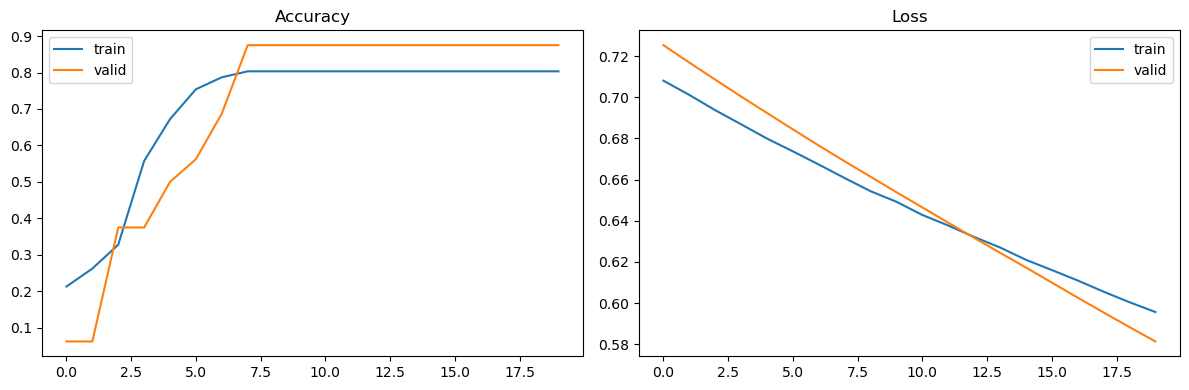

In [22]:
plot_acc(history)

In [23]:
y_pred = dl_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [24]:
y_pred[0:5] #confidence levels

array([[0.61008537, 0.38991457],
       [0.606537  , 0.39346305],
       [0.58887047, 0.41112953],
       [0.5841692 , 0.41583076],
       [0.5790206 , 0.42097938]], dtype=float32)

2 methods:
1. We convert all decimals to int, that way they'll be a whole number (1 or 0). Cannot give a label for sure (all may be 0). This could be a good option to make sure that we are not naively assigning labels
2. The prediction needs to be converted to 1 and 0. For each row, the highest value is the label and the "predicted" number is the confidence level.

In [25]:
prediction = pd.DataFrame(y_pred, columns=le.classes_)
prediction.head()

,co,rbt
0,0.610085,0.389915
1,0.606537,0.393463
2,0.588870,0.411130
3,0.584169,0.415831
4,0.579021,0.420979


In [26]:
y_test[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])